# Weather file - gap filling and formatting
- Main tasks: 
    1. gap fill weather file
    2. combine met and solrad info into single files for each site-year
    3. address timezone issue
    4. format weather file into MAIZSIM-readable format
- Data source: 
    1. weadata/**temp_all.csv**
    2. weadata/**rh_all.csv**
    3. weadata/**precip_all.csv**
    4. weadata/**solrad_all.csv**
- Main output: 
    - weadata/data/control/**site_year.txt** - weather file for all site-years

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import xarray as xr
import datetime
import time 
from timezonefinder import TimezoneFinder
import pytz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5

### Step 0: Reading in temperature, precip, RH & solar radiation data:
- Main input:
    - /weadata/**temp_all.csv**
    - /weadata/**rh_all.csv**
    - /weadata/**precip_all.csv**
    - /weadata/**solrad_all.csv**
- Main output: 
    - **df_temp, df_rh, df_precip, df_solrad**

#### 0.1 Read in weather data 1961-1990

In [2]:
# read in individual weather data
df_temp_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_6190.csv', index_col=0)
df_rh_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_6190.csv', index_col=0)
df_precip_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_6190.csv', index_col=0)
df_solrad_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_6190.csv', index_col=0)

# re-index solar radiation data to only include growing season
df_solrad_6190 = df_solrad_6190.reindex(df_temp_6190.index)

# check that all met elements aligned - dataframe shape should match
print(df_temp_6190.shape)
print(df_rh_6190.shape)
print(df_precip_6190.shape)
print(df_solrad_6190.shape)

# convert station ID header from WBAN to USAF (in order to make continuous with 1991-2010)
df_stations = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/stations_wban_usaf.csv', header=None, dtype='str')
df_stations.columns = ['WBAN', 'USAF']
sites_wban = list(df_temp_6190.columns)
sites_usaf = df_stations[df_stations['WBAN'].isin(sites_wban)]['USAF']

# assign new USAF headers
df_temp_6190.columns = sites_usaf; df_temp_6190 = df_temp_6190.sort_index(axis=1)
df_rh_6190.columns = sites_usaf; df_rh_6190 = df_rh_6190.sort_index(axis=1)
df_precip_6190.columns = sites_usaf; df_precip_6190 = df_precip_6190.sort_index(axis=1)
df_solrad_6190.columns = sites_usaf; df_solrad_6190 = df_solrad_6190.sort_index(axis=1)

(198000, 237)
(198000, 237)
(198000, 237)
(198000, 237)


#### 0.2 Read in weather data 1991-2010

In [126]:
## read in individual weather data
df_temp_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/temp_9110_class1_test1.csv', index_col=0)
df_rh_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/rh_9110_class1_test1.csv', index_col=0)
df_precip_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/precip_9110_class1_test1.csv', index_col=0)
df_solrad_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/solrad_9110_class1.csv', index_col=0)

# re-index solar radiation data to only include growing season
df_solrad_9110 = df_solrad_9110.reindex(df_temp_9110.index)

# check that all met elements aligned - dataframe shape should match
print(df_temp_9110.shape)
print(df_rh_9110.shape)
print(df_precip_9110.shape)
print(df_solrad_9110.shape)

(132000, 241)
(132000, 241)
(132000, 241)
(132000, 242)


In [130]:
## read in individual weather data
df_temp_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/temp_9110_class1_test2.csv', index_col=0)
df_rh_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/rh_9110_class1_test2.csv', index_col=0)
df_precip_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/precip_9110_class1_test2.csv', index_col=0)
df_solrad_9110 = pd.read_csv( '/home/disk/eos8/ach315/upscale/weadata/solrad_9110_class1.csv', index_col=0)

# re-index solar radiation data to only include growing season
df_solrad_9110 = df_solrad_9110.reindex(df_temp_9110.index)

# check that all met elements aligned - dataframe shape should match
print(df_temp_9110.shape)
print(df_rh_9110.shape)
print(df_precip_9110.shape)
print(df_solrad_9110.shape)

(132000, 241)
(132000, 241)
(132000, 241)
(132000, 242)


#### 0.3 Stitch together weather data

In [132]:
df_temp = pd.concat([df_temp_6190, df_temp_9110], axis=0, join='outer'); df_temp = df_temp.sort_index(axis=1)
df_rh = pd.concat([df_rh_6190, df_rh_9110], axis=0, join='outer'); df_rh = df_rh.sort_index(axis=1)
df_precip = pd.concat([df_precip_6190, df_precip_9110], axis=0, join='outer'); df_precip = df_precip.sort_index(axis=1)
df_solrad = pd.concat([df_solrad_6190, df_solrad_9110], axis=0, join='outer'); df_solrad = df_solrad.sort_index(axis=1)

print(df_temp.shape)
print(df_rh.shape)
print(df_precip.shape)
print(df_solrad.shape)

(330000, 274)
(330000, 274)
(330000, 274)
(330000, 274)


### Step 1. Figure out valid site-years that can be gap-filled
Selecting for site-years based on **crit_hrs** - consecutive missing hours of datapoints within raw data
- Main input: **df_temp, df_precip, df_solrad**
- Main output: **finalist**

In [133]:
# input variables for loop
datasets = list([df_temp, df_precip, df_solrad]) # weather datasets to process
                                                 # df_rh is based off df_temp, so no need to evaluate 

finalist = list([[], [], []]) # final lists to store processed output
                              # order: [0]-temp, [1]-precip, [2]-solrad

years = np.arange(1961, 2011) # years
growseason_start = '-03-01 00:00:00'
growseason_end = '-11-30 23:00:00' 

crit_hrs = 1 # critical hrs of missing data

# loop through temp, precip & solrad dataset to pick out usable site-years
for i in np.arange(len(datasets)):
    dataset = datasets[i]
    siteyears_all = list()
    sites = dataset.columns
    
    for j in years:
        start_time = str(j) + growseason_start
        end_time = str(j) + growseason_end
        siteyears = list()
        
        for k in sites:
            df = dataset.loc[start_time:end_time, k] 
            df = pd.DataFrame(df)
            df['group'] = df.notnull().astype(int) # df.notnull() returns TRUE or FALSE, 
                                                   # .astype(int) turns TRUE into 1, and FALSE into 0
            df['group'] = df.group.cumsum() # calculating cumulative sum 
            df = df[df.iloc[:,0].isnull()] # selecting out individual timesteps that have missing data
            df['count'] = df.groupby('group')['group'].transform('size') # counts the number of consecutive NANs 
            df = df.drop_duplicates('group')
            
            if df[df['count'] > crit_hrs].shape[0] == 0:
                use_siteyear = str(j) + '_' + str(k)
                siteyears.append(use_siteyear) # only record site-years that have fewer consecutive NANs than the critical value set
        
        siteyears_all.extend(siteyears)
    
    finalist[i] = siteyears_all

### Step 2. Compare usable site-years for temp  & precip and find the common year-sites
- Main intput: **finalist**
- Main output: **siteyears**

# 200707 - why overlapping siteyears went down?

In [77]:
# assign output to individual siteyears
siteyears_temp = finalist[0]
siteyears_precip = finalist[1]
siteyears_solrad = finalist[2]
print('temp:', len(siteyears_temp))
print('precip:', len(siteyears_precip))
print('solrad:', len(siteyears_solrad))

# identify overlapping siteyears
siteyears = list(set(siteyears_temp) & set(siteyears_precip))
siteyears = list(set(siteyears) & set(siteyears_solrad))
siteyears.sort()

# change depending on critical hours
siteyears_crithr1 = siteyears

print('overlapping siteyears:', len(siteyears))

temp: 4298
precip: 3154
solrad: 11937
overlapping siteyears: 3021


In [102]:
# assign output to individual siteyears
siteyears_temp = finalist[0]
siteyears_precip = finalist[1]
siteyears_solrad = finalist[2]
print('temp:', len(siteyears_temp))
print('precip:', len(siteyears_precip))
print('solrad:', len(siteyears_solrad))

# identify overlapping siteyears
siteyears = list(set(siteyears_temp) & set(siteyears_precip))
siteyears = list(set(siteyears) & set(siteyears_solrad))
siteyears.sort()

# change depending on critical hours
siteyears_crithr1 = siteyears

print('overlapping siteyears:', len(siteyears))

temp: 4299
precip: 6946
solrad: 11837
overlapping siteyears: 3508


### Step 3. Visualization - available site-years vs. consecutive missing data hours

<BarContainer object of 4 artists>

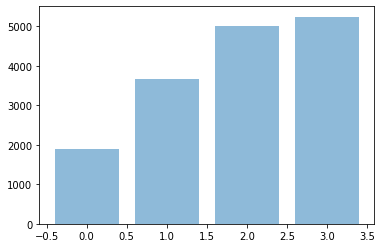

In [68]:
# calculate available site-years
crithrs_0 = len(siteyears_crithr0)
crithrs_1 = len(siteyears_crithr1)
crithrs_2 = len(siteyears_crithr2)
crithrs_3 = len(siteyears_crithr3)

# visualization
x = [0,1,2,3]
width =  [crithrs_0, crithrs_1, crithrs_2, crithrs_3]
plt.bar(x, width, alpha=0.5)

### Step 4. Store basic info of valid site-years
- Main input: **siteyears_crithr1**
- Main output: 
    - weadata/**siteyears_crithr1.csv** - site-year info for data filtered with crithr = 1
    - weadata/**site_nyears_crithr1.csv** - info on how many years of wea data each site has

In [7]:
siteyears = siteyears_crithr1

# what are the valid site-years?
years = list()
sites = list()

for i in range(len(siteyears)):
    year = siteyears[i][0:4]
    years.append(year)
    site = siteyears[i][5:11] 
    sites.append(site)

df_siteyears = pd.DataFrame({'site': sites, 'year': years}, 
                            columns=['site', 'year'])
df_siteyears = df_siteyears.sort_values(['site', 'year'])
final_sites = list(set(df_siteyears.site))
#df_siteyears.to_csv('../weadata/siteyears_crithr1.csv')

In [8]:
# how many years of data do each site have?
site_nyears = list()

for i in final_sites:
    years = len(df_siteyears[df_siteyears["site"] == i])
    site_nyears.append(years)
    
df_site_nyears = pd.DataFrame({"site": final_sites, "years": site_nyears})
df_site_nyears = df_site_nyears.sort_values(["site"])
df_site_nyears = df_site_nyears.reset_index().iloc[:, 1:3]
#df_site_nyears.to_csv("../weadata/site_nyears_crithr1.csv")

### Step 5: Filter sites based on planting area & irrigation

#### 5.1 Select sites with valid weather data

In [9]:
# read in station & site-year info
df_site_nyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_nyears_crithr1_test.csv', index_col=0)
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', usecols=[0,1,3,4,8,9,10])
df_sites_info = df_stations_9110[df_stations_9110.USAF.isin(df_site_nyears.site)]
df_sites_info.columns = ['site', 'class', 'station', 'state', 'tzone', 'lat', 'lon']

# merge site info & site-years info
df_sites_info = pd.merge(df_sites_info, df_site_nyears, on='site')

# drop stations from Alaska, Guam, Hawaii & Puerto Rico
df_sites_info = df_sites_info[(df_sites_info.state != 'AK') & (df_sites_info.state != 'GU') & 
                              (df_sites_info.state != 'HI')& (df_sites_info.state != 'PR')]

# final station list
df_sites_info.reset_index(inplace=True, drop=True)
df_sites_info.head()

,site,class,station,state,tzone,lat,lon,years
0,722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,13
1,722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,25
2,722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,10
3,722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,16
4,722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,11


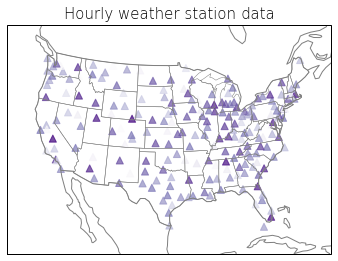

In [10]:
# create map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sites_info['lon'], df_sites_info['lat'], 
           transform=ccrs.PlateCarree(), 
           c=df_sites_info.years.astype(float), cmap=Purples_9.mpl_colormap,
           s=50, marker='^', alpha=0.7)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Hourly weather station data', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#### 5.2 Include planting area & irrigation info

In [12]:
state = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/stateID.txt', header=None, sep='\s+')
county = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/countyID.txt', header=None, sep='\s+')
lat = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/lat_county.txt', header=None, sep='\s+')
lon = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/lon_county.txt', header=None, sep='\s+')
irri = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/irr_area_acres.txt', header=None, sep='\s+')
area = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/crop_area_acres.txt', header=None, sep='\s+')
state = state.iloc[0,:]
county = county.iloc[0,:]
lat = lat.iloc[0,:]
lon = lon.iloc[0,:]

# raw data includes data from 4 censuses that show data of 1997, 2002, 2007 & 2012
# we average data from all 4 censuses 
irri = irri.mean(axis=1)
area = area.mean(axis=1)
df_obs = pd.DataFrame({'state': state, 'county': county, 'lat': lat, 'lon': lon, 
                       'irri_area': irri, 'crop_area': area, 'perct_irri': irri/area*100})
df_obs.head()

,state,county,lat,lon,irri_area,crop_area,perct_irri
0,1.0,1.0,32.430976,-86.714727,973.500000,46089.75,2.112183
1,1.0,3.0,30.569698,-87.688916,9337.750000,109721.50,8.510410
2,1.0,5.0,31.907512,-85.306271,2850.000000,57627.75,4.945534
3,1.0,7.0,33.069184,-87.075724,83.333333,13352.25,0.624115
4,1.0,9.0,34.021667,-86.653387,532.750000,56643.25,0.940536


In [13]:
sites = df_sites_info.site
areas = []
perct_irris = []

for site in sites:
    lat = float(df_sites_info[df_sites_info.site == site].lat)
    lon = float(df_sites_info[df_sites_info.site == site].lon)
    dist = list(enumerate(np.sqrt((lat - df_obs.lat)**2 + (lon - (df_obs.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    row = list(df_dist.nsmallest(5, 'distance').rownum) # select the five nearest locations and average for
                                                        # cropping area & irrigation percentage
    area = df_obs.iloc[row].crop_area.mean()
    perct_irri = df_obs.iloc[row].perct_irri.mean()
    areas.append(area)
    perct_irris.append(perct_irri)

# add planting area & irrigation info for filtering purposes
df_filter = pd.DataFrame({'area': areas, 'perct_irri': perct_irris})
df_summary = pd.concat([df_sites_info, df_filter], axis=1)

#### 5.3 Filter out sites with low planting and/or high irrigation

In [14]:
# filter
df_filtered = df_summary[(df_summary.area > 50000) & (df_summary.perct_irri < 10)]
# Mueller & Butler (2018) - 'counties with >10% of their harvested areas irrigated according to the four 1997-2012 census
# are removed from the anlaysis, as they are known to be significantly less sensitive to temperature.'

# how many site-years left?
print('prior:', sum(df_summary.years.astype(int)))
print('after filtering:', sum(df_filtered.years.astype(int)))

# store final filtered site info
#df_filtered.to_csv('/home/disk/eos8/ach315/upscale/weadata/sites_filtered_crithr1.csv')

prior: 2925
after filtering: 1153


In [371]:
df_filtered.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
14,722260,1,MONTGOMERY DANNELLY FIELD,AL,-6,32.300,-86.400,18,51171.050000,3.842579
19,722350,1,JACKSON INTERNATIONAL AP,MS,-6,32.317,-90.083,19,56413.100000,0.799531
22,722430,1,HOUSTON BUSH INTERCONTINENTAL,TX,-6,30.000,-95.367,17,84770.050000,6.818347
24,722480,1,SHREVEPORT REGIONAL ARPT,LA,-6,32.450,-93.817,27,50774.950000,2.675218
26,722510,1,CORPUS CHRISTI INTL ARPT [UT],TX,-6,27.767,-97.517,20,181126.083333,1.253455


#### 5.4 Visualization

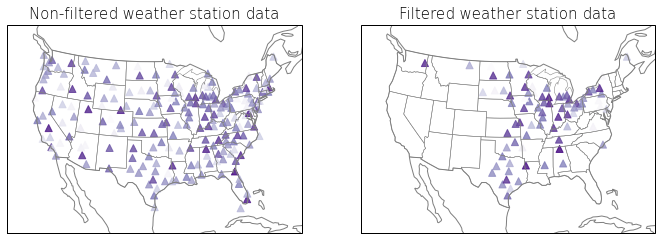

In [367]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

# sites not filtered
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1, 
                      projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(df_summary.lon.astype(float), df_summary.lat.astype(float), 
            transform=ccrs.PlateCarree(), s=50, marker='^', 
            c=df_summary.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Non-filtered weather station data', fontweight='light', fontsize=15)


# sites filtered
ax2 = fig.add_subplot(1,2,2,
                      projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
ax2.scatter(df_filtered.lon.astype(float), df_filtered.lat.astype(float), 
            transform=ccrs.PlateCarree(), s=50, marker='^', 
            c=df_filtered.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.8)

ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Filtered weather station data', fontweight='light', fontsize=15)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

### Step 6: Compile and gap-fill usable site-years data into individual weather data files
- Main tasks:
    - figure out time zone for individual site and convet wea data from UTC into local time
    - gap-fill wea data by linearly interpolating with data from hour before and after
- Main input:
    - /weadata/**stations_info.csv** - city, state, lat, lon info for each site
    - /weadata/**siteyears_crithr1.csv** - site-year info for data filtered with crithr = 1
    - df_temp, df_rh, df_precip, df_solrad
- Main output:
    - /weadata/data/control/**site_year.txt** - MAIZSIM weather file for every site-year
- Functions:
    - find_zone(site)
    - utc_to_local(times, zone)

In [39]:
# time zone finder
def find_zone(site):
    """
    find time zone for specific sites
    """
    lat = float(siteinfo[siteinfo.site == site].lat)
    lon = float(siteinfo[siteinfo.site == site].lon)
    tf = TimezoneFinder()    
    zone = tf.timezone_at(lng=lon, lat=lat)
    return zone

In [40]:
# utc conversion to local time
def utc_to_local(times, zone):
    """
    convert list of utc timestamps into local time
    """
    times = times.to_pydatetime() # convert from pd.DatetimeIndex into python datetime format
    utc = pytz.timezone('UTC') # setting up the UTC timezone, requires package 'pytz'
    local_datetime = list()
    
    for time in times:
        utctime = utc.localize(time) # adding UTC timezone to datetime
        localtime = utctime.astimezone(pytz.timezone(zone)) 
        datetime = pd.to_datetime(localtime)
        local_datetime.append(datetime)
        
    return local_datetime

In [41]:
# 200706 - updating code - testing

### setting up growing season period
season_start, season_end = '03-02', '11-30'

### reading in required files
siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/sites_filtered_crithr1.csv', 
                       dtype={'site': object}, usecols=[1,4,5,6,7])
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv', 
                       dtype={'site':object}, usecols=[1,2])
siteyear = siteyear[siteyear.site.isin(siteinfo.site)]
siteyear.reset_index(inplace=True, drop=True)

In [15]:
plt.scatter(siteyear.site, siteyear.year, alpha=0.8)
plt.title('Site-years available')

NameError: name 'siteyear' is not defined

#### %%time
# 200706 - updating code - testing
siteyear = siteyear.iloc[:10,:] # test with few cases first

for i in np.arange(siteyear.shape[0]):
    # selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    print(site, year)
    
    # constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    # setting up for time-relating entries
    times = pd.date_range(season_start + '-' + str(year), 
                          season_end + '-' + str(year)+ ' 23:00:00', freq='1H') # utc time
    zone = find_zone(site)
    local_datetime = utc_to_local(times, zone)

    # selecting weather data
    utc_start, utc_end = str(times[0]), str(times[-1])
    df_wea.temp = list(df_temp[utc_start:utc_end][site])
    df_wea.rh = list(np.round((df_rh[utc_start:utc_end][site])*100, 2))
    df_wea.precip = list(df_precip[utc_start:utc_end][site])
    df_wea.co2 = 400    

    # selecting solar radiation 
    t1 = pd.to_datetime(utc_start).to_pydatetime()
    t2 = pd.to_datetime(utc_end).to_pydatetime()
    tdiff = t2-t1
    local_start = str(local_datetime[0])[:19] 
    local_end = str(pd.to_datetime(local_start).to_pydatetime() + tdiff)[:19]
    df_wea.solrad = list(df_solrad[local_start:local_end][site])
    
    # adding time-relating info to data frame
    local = pd.date_range(local_start, local_end, freq='H')
    df_wea.jday = local.dayofyear
    df_wea.date = local.strftime("'%m/%d/%Y'")
    df_wea.hour = local.hour    
    
    # gap-filling weather data
    if df_wea.isna().sum().sum() > 0:
        # creating a log file that documents the number of missing data for each site-year
        f = open('/home/disk/eos8/ach315/upscale/weadata/data/log.txt', 'a+')
        f.write(siteyear.iloc[i,:][0]) # site
        f.write(', %s' %siteyear.iloc[i,:][1]) # year
        f.write(', %s' %df_wea.isna().sum().temp) # temp
        f.write(', %s' %df_wea.isna().sum().rh) # rh
        f.write(', %s' %df_wea.isna().sum().precip) # precip
        f.write(', %s\r\n' %df_wea.isna().sum().solrad) # solrad
        f.close()
        
        # gap-filling data by linearly interpolating with data from hour before and after
        df_wea = df_wea.interpolate() 
        
    # saving individual site-year weather file into .csv 
#    df_wea.to_csv('/home/disk/eos8/ach315/upscale/weadata/data/test/' + site + '_' + year + '.txt', sep='\t', index=False)


In [ ]:
%%time # code block run time ~52 mins

### setting up growing season period
season_start, season_end = '03-01', '11-30'

### reading in required files
siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv', dtype='str', usecols=[1,2,3,4,5])
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv', dtype='str', usecols=[1,2])

### starting the loop to process each site-year
for i in np.arange(siteyear.shape[0]): 
    # selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    print(site, year)
    
    # constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    # setting up for time-relating entries
    times = pd.date_range(season_start + '-' + str(year), 
                          season_end + '-' + str(year)+ ' 23:00:00', freq='1H') # utc time
    zone = find_zone(site)
    local_datetime = utc_to_local(times, zone)
            
    # selecting weather data
    utc_start, utc_end = str(times[0]), str(times[-1])
    df_wea.temp = list(df_temp[utc_start:utc_end][site])
    df_wea.rh = list(np.round((df_rh[utc_start:utc_end][site])*100, 2))
    df_wea.precip = list(df_precip[utc_start:utc_end][site]/10) #*** this is a temporary fix for precip scaling bug
    df_wea.co2 = 400    

    # selecting solar radiation 
    t1 = pd.to_datetime(utc_start).to_pydatetime()
    t2 = pd.to_datetime(utc_end).to_pydatetime()
    tdiff = t2-t1
    local_start = str(local_datetime[0])[:19] 
    local_end = str(pd.to_datetime(local_start).to_pydatetime() + tdiff)[:19]
    df_wea.solrad = list(df_solrad[local_start:local_end][site])

    # adding time-relating info to data frame
    local = pd.date_range(local_start, local_end, freq='H')
    df_wea.jday = local.dayofyear
    df_wea.date = local.strftime("'%m/%d/%Y'")
    df_wea.hour = local.hour    
    
    # gap-filling weather data
    if df_wea.isna().sum().sum() > 0:
        # creating a log file that documents the number of missing data for each site-year
        f = open('/home/disk/eos8/ach315/upscale/weadata/data/log.txt', 'a+')
        f.write('site: %s' %siteyear.iloc[i,:][0])
        f.write(', year: %s' %siteyear.iloc[i,:][1])
        f.write(', gap-filled: %s\r\n' %df_wea.isna().sum().sum())
        f.close()
        
        # gap-filling data by linearly interpolating with data from hour before and after
        df_wea = df_wea.interpolate() 
        
    # saving individual site-year weather file into .csv 
#    df_wea.to_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/' + site + '_' + year + '.txt', sep='\t', index=False)
    

### Step 7: Final step of gap-filling if needed

Since pd.interpolate() cannot gap-fill missing data if the missing data is located at the very beginning of the data (nan in first row), the code checks whether there are site-years with that situation, and if so assigns the missing data in the first row a default number.

In [1354]:
fnames = glob.glob('/home/disk/eos8/ach315/upscale/weadata/data/control/*')

for name in fnames: 
    df_wea = pd.read_csv(name)
    df_wea = df_wea.drop(df_wea.columns[0], axis=1)
    if df_wea.isna().sum().sum() > 0:
        print(name.split('/')[-1], df_wea.isna().sum().sum())

# no files required additional gap-filling

### Step 8: reading in a final compiled weather file to check output

In [25]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/24127_1989.txt', sep='\t')
test.head()

,jday,date,hour,solrad,temp,precip,rh,co2
0,90,'03/31/1989',17,29.0,7.8,0.0,76.18,400
1,90,'03/31/1989',18,4.0,5.6,1.3,85.04,400
2,90,'03/31/1989',19,0.0,6.1,2.5,88.77,400
3,90,'03/31/1989',20,0.0,6.1,0.0,85.69,400
4,90,'03/31/1989',21,0.0,6.1,0.0,82.13,400
